<a href="https://colab.research.google.com/github/ForestHouse2316/KoreanOCR-for-Web/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and initial variables setting

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib as plt
import numpy as np
import dataset.py

     |████████████████████████████████| 380.5MB 42kB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 4.3MB 33.7MB/s 
     |████████████████████████████████| 501kB 49.3MB/s 


ModuleNotFoundError: ignored

## Dataset Class

In [ ]:
import os
import argparse
import random

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_path, opt, shuffle=True, train=True):
        self.path = data_path
        self.file_names = os.listdir(data_path)
        self.n_samples = len(self.file_names)
        #random.shuffle(self.file_names)
        self.shuffle=shuffle
        self.train=train
        
        self.batch_size = opt.batch_size
        self.num_class = len(opt.character)
        
        self.idx_to_char = list(opt.character)
        self.char_to_idx = {}
        for i, char in enumerate(self.idx_to_char):
            self.char_to_idx[char] = i
            
        self.on_epoch_end()
        print(f'{self.n_samples} images loaded')
    
    def __len__(self):
        return int(np.floor(self.n_samples / self.batch_size))
    
    def on_epoch_end(self):
        self.indices = np.arange(self.n_samples)
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        files = [self.file_names[i] for i in indices]#range(index*self.batch_size, (index+1)*self.batch_size)]
        xs = []
        ys = []
        
        for file in files:
            x = load_img(os.path.join(self.path, file), target_size=(32,32))
            x = img_to_array(x)
            x = x / 255.
            xs.append(x)
            
            if self.train == True:
                label = file[0]
                ys.append(self.char_to_idx[label])
        
        return np.array(xs), np.array(ys)
        
class DataGeneratorByPath(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, opt, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = opt.batch_size
        self.shuffle = shuffle
        
        self.idx_to_char = list(opt.character)#['?'] + list(opt.character)
        self.char_to_idx = {}
        for i, char in enumerate(self.idx_to_char):
            self.char_to_idx[char] = i#+1
        #self.char_to_idx[self.idx_to_char[0]] = 0
        
        self.num_class = len(self.idx_to_char)
        self.n_samples = len(self.file_paths)
        
        self.on_epoch_end()
        print(f'{self.n_samples} images loaded')
    
    def __len__(self):
        return int(np.floor(self.n_samples / self.batch_size))
    
    def on_epoch_end(self):
        self.indices = np.arange(self.n_samples)
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        files = [self.file_paths[i] for i in indices]
        labels = [self.labels[i] for i in indices]
        xs = []
        ys = []
        
        for file, label in zip(files, labels):
            x = load_img(file, target_size=(32,32))
            x = img_to_array(x)
            x = x / 255.
            xs.append(x)
            
            ys.append(self.char_to_idx[label])
        
        return np.array(xs), np.array(ys)

## Build-up for ML

In [ ]:
dataStructure_path = '/content/drive/MyDrive/Colab Notebooks/OCR/train_data_info_omitted.csv'
dataStructure_df = pd.read_csv(dataStructure_path)
dataStructure_df.head(10)

In [ ]:
outputLayerClassName = list('가각간갇갈갉갊감갑값갓갔강갖갗같갚갛개객갠갤갬갭갯갰갱갸갹갼걀걋걍걔걘걜거걱건걷걸걺검겁것겄겅겆겉겊겋게겐겔겜겝겟겠겡겨격겪견겯결겸겹겻겼경곁계곈곌곕곗고곡곤곧골곪곬곯곰곱곳공곶과곽관괄괆괌괍괏광괘괜괠괩괬괭괴괵괸괼굄굅굇굉교굔굘굡굣구국군굳굴굵굶굻굼굽굿궁궂궈궉권궐궜궝궤궷귀귁귄귈귐귑귓규균귤그극근귿글긁금급긋긍긔기긱긴긷길긺김깁깃깅깆깊까깍깎깐깔깖깜깝깟깠깡깥깨깩깬깰깸깹깻깼깽꺄꺅꺌꺼꺽꺾껀껄껌껍껏껐껑께껙껜껨껫껭껴껸껼꼇꼈꼍꼐꼬꼭꼰꼲꼴꼼꼽꼿꽁꽂꽃꽈꽉꽐꽜꽝꽤꽥꽹꾀꾄꾈꾐꾑꾕꾜꾸꾹꾼꿀꿇꿈꿉꿋꿍꿎꿔꿜꿨꿩꿰꿱꿴꿸뀀뀁뀄뀌뀐뀔뀜뀝뀨끄끅끈끊끌끎끓끔끕끗끙끝끼끽낀낄낌낍낏낑나낙낚난낟날낡낢남납낫났낭낮낯낱낳내낵낸낼냄냅냇냈냉냐냑냔냘냠냥너넉넋넌널넒넓넘넙넛넜넝넣네넥넨넬넴넵넷넸넹녀녁년녈념녑녔녕녘녜녠노녹논놀놂놈놉놋농높놓놔놘놜놨뇌뇐뇔뇜뇝뇟뇨뇩뇬뇰뇹뇻뇽누눅눈눋눌눔눕눗눙눠눴눼뉘뉜뉠뉨뉩뉴뉵뉼늄늅늉느늑는늘늙늚늠늡늣능늦늪늬늰늴니닉닌닐닒님닙닛닝닢다닥닦단닫달닭닮닯닳담답닷닸당닺닻닿대댁댄댈댐댑댓댔댕댜더덕덖던덛덜덞덟덤덥덧덩덫덮데덱덴델뎀뎁뎃뎄뎅뎌뎐뎔뎠뎡뎨뎬도독돈돋돌돎돐돔돕돗동돛돝돠돤돨돼됐되된될됨됩됫됴두둑둔둘둠둡둣둥둬뒀뒈뒝뒤뒨뒬뒵뒷뒹듀듄듈듐듕드득든듣들듦듬듭듯등듸디딕딘딛딜딤딥딧딨딩딪따딱딴딸땀땁땃땄땅땋때땍땐땔땜땝땟땠땡떠떡떤떨떪떫떰떱떳떴떵떻떼떽뗀뗄뗌뗍뗏뗐뗑뗘뗬또똑똔똘똥똬똴뙈뙤뙨뚜뚝뚠뚤뚫뚬뚱뛔뛰뛴뛸뜀뜁뜅뜨뜩뜬뜯뜰뜸뜹뜻띄띈띌띔띕띠띤띨띰띱띳띵라락란랄람랍랏랐랑랒랖랗래랙랜랠램랩랫랬랭랴략랸럇량러럭런럴럼럽럿렀렁렇레렉렌렐렘렙렛렝려력련렬렴렵렷렸령례롄롑롓로록론롤롬롭롯롱롸롼뢍뢨뢰뢴뢸룀룁룃룅료룐룔룝룟룡루룩룬룰룸룹룻룽뤄뤘뤠뤼뤽륀륄륌륏륑류륙륜률륨륩륫륭르륵른를름릅릇릉릊릍릎리릭린릴림립릿링마막만많맏말맑맒맘맙맛망맞맡맣매맥맨맬맴맵맷맸맹맺먀먁먈먕머먹먼멀멂멈멉멋멍멎멓메멕멘멜멤멥멧멨멩며멱면멸몃몄명몇몌모목몫몬몰몲몸몹못몽뫄뫈뫘뫙뫼묀묄묍묏묑묘묜묠묩묫무묵묶문묻물묽묾뭄뭅뭇뭉뭍뭏뭐뭔뭘뭡뭣뭬뮈뮌뮐뮤뮨뮬뮴뮷므믄믈믐믓미믹민믿밀밂밈밉밋밌밍및밑바박밖밗반받발밝밞밟밤밥밧방밭배백밴밸뱀뱁뱃뱄뱅뱉뱌뱍뱐뱝버벅번벋벌벎범법벗벙벚베벡벤벧벨벰벱벳벴벵벼벽변별볍볏볐병볕볘볜보복볶본볼봄봅봇봉봐봔봤봬뵀뵈뵉뵌뵐뵘뵙뵤뵨부북분붇불붉붊붐붑붓붕붙붚붜붤붰붸뷔뷕뷘뷜뷩뷰뷴뷸븀븃븅브븍븐블븜븝븟비빅빈빌빎빔빕빗빙빚빛빠빡빤빨빪빰빱빳빴빵빻빼빽뺀뺄뺌뺍뺏뺐뺑뺘뺙뺨뻐뻑뻔뻗뻘뻠뻣뻤뻥뻬뼁뼈뼉뼘뼙뼛뼜뼝뽀뽁뽄뽈뽐뽑뽕뾔뾰뿅뿌뿍뿐뿔뿜뿟뿡쀼쁑쁘쁜쁠쁨쁩삐삑삔삘삠삡삣삥사삭삯산삳살삵삶삼삽삿샀상샅새색샌샐샘샙샛샜생샤샥샨샬샴샵샷샹섀섄섈섐섕서석섞섟선섣설섦섧섬섭섯섰성섶세섹센셀셈셉셋셌셍셔셕션셜셤셥셧셨셩셰셴셸솅소속솎손솔솖솜솝솟송솥솨솩솬솰솽쇄쇈쇌쇔쇗쇘쇠쇤쇨쇰쇱쇳쇼쇽숀숄숌숍숏숑수숙순숟술숨숩숫숭숯숱숲숴쉈쉐쉑쉔쉘쉠쉥쉬쉭쉰쉴쉼쉽쉿슁슈슉슐슘슛슝스슥슨슬슭슴습슷승시식신싣실싫심십싯싱싶싸싹싻싼쌀쌈쌉쌌쌍쌓쌔쌕쌘쌜쌤쌥쌨쌩썅써썩썬썰썲썸썹썼썽쎄쎈쎌쏀쏘쏙쏜쏟쏠쏢쏨쏩쏭쏴쏵쏸쐈쐐쐤쐬쐰쐴쐼쐽쑈쑤쑥쑨쑬쑴쑵쑹쒀쒔쒜쒸쒼쓩쓰쓱쓴쓸쓺쓿씀씁씌씐씔씜씨씩씬씰씸씹씻씽아악안앉않알앍앎앓암압앗았앙앝앞애액앤앨앰앱앳앴앵야약얀얄얇얌얍얏양얕얗얘얜얠얩어억언얹얻얼얽얾엄업없엇었엉엊엌엎에엑엔엘엠엡엣엥여역엮연열엶엷염엽엾엿였영옅옆옇예옌옐옘옙옛옜오옥온올옭옮옰옳옴옵옷옹옻와왁완왈왐왑왓왔왕왜왝왠왬왯왱외왹왼욀욈욉욋욍요욕욘욜욤욥욧용우욱운울욹욺움웁웃웅워웍원월웜웝웠웡웨웩웬웰웸웹웽위윅윈윌윔윕윗윙유육윤율윰윱윳융윷으윽은을읊음읍읏응읒읓읔읕읖읗의읜읠읨읫이익인일읽읾잃임입잇있잉잊잎자작잔잖잗잘잚잠잡잣잤장잦재잭잰잴잼잽잿쟀쟁쟈쟉쟌쟎쟐쟘쟝쟤쟨쟬저적전절젊점접젓정젖제젝젠젤젬젭젯젱져젼졀졈졉졌졍졔조족존졸졺좀좁좃종좆좇좋좌좍좔좝좟좡좨좼좽죄죈죌죔죕죗죙죠죡죤죵주죽준줄줅줆줌줍줏중줘줬줴쥐쥑쥔쥘쥠쥡쥣쥬쥰쥴쥼즈즉즌즐즘즙즛증지직진짇질짊짐집짓징짖짙짚짜짝짠짢짤짧짬짭짯짰짱째짹짼쨀쨈쨉쨋쨌쨍쨔쨘쨩쩌쩍쩐쩔쩜쩝쩟쩠쩡쩨쩽쪄쪘쪼쪽쫀쫄쫌쫍쫏쫑쫓쫘쫙쫠쫬쫴쬈쬐쬔쬘쬠쬡쭁쭈쭉쭌쭐쭘쭙쭝쭤쭸쭹쮜쮸쯔쯤쯧쯩찌찍찐찔찜찝찡찢찧차착찬찮찰참찹찻찼창찾채책챈챌챔챕챗챘챙챠챤챦챨챰챵처척천철첨첩첫첬청체첵첸첼쳄쳅쳇쳉쳐쳔쳤쳬쳰촁초촉촌촐촘촙촛총촤촨촬촹최쵠쵤쵬쵭쵯쵱쵸춈추축춘출춤춥춧충춰췄췌췐취췬췰췸췹췻췽츄츈츌츔츙츠측츤츨츰츱츳층치칙친칟칠칡침칩칫칭카칵칸칼캄캅캇캉캐캑캔캘캠캡캣캤캥캬캭컁커컥컨컫컬컴컵컷컸컹케켁켄켈켐켑켓켕켜켠켤켬켭켯켰켱켸코콕콘콜콤콥콧콩콰콱콴콸쾀쾅쾌쾡쾨쾰쿄쿠쿡쿤쿨쿰쿱쿳쿵쿼퀀퀄퀑퀘퀭퀴퀵퀸퀼큄큅큇큉큐큔큘큠크큭큰클큼큽킁키킥킨킬킴킵킷킹타탁탄탈탉탐탑탓탔탕태택탠탤탬탭탯탰탱탸턍터턱턴털턺텀텁텃텄텅테텍텐텔템텝텟텡텨텬텼톄톈토톡톤톨톰톱톳통톺톼퇀퇘퇴퇸툇툉툐투툭툰툴툼툽툿퉁퉈퉜퉤튀튁튄튈튐튑튕튜튠튤튬튱트특튼튿틀틂틈틉틋틔틘틜틤틥티틱틴틸팀팁팃팅파팍팎판팔팖팜팝팟팠팡팥패팩팬팰팸팹팻팼팽퍄퍅퍼퍽펀펄펌펍펏펐펑페펙펜펠펨펩펫펭펴편펼폄폅폈평폐폘폡폣포폭폰폴폼폽폿퐁퐈퐝푀푄표푠푤푭푯푸푹푼푿풀풂품풉풋풍풔풩퓌퓐퓔퓜퓟퓨퓬퓰퓸퓻퓽프픈플픔픕픗피픽핀필핌핍핏핑하학한할핥함합핫항해핵핸핼햄햅햇했행햐향허헉헌헐헒험헙헛헝헤헥헨헬헴헵헷헹혀혁현혈혐협혓혔형혜혠혤혭호혹혼홀홅홈홉홋홍홑화확환활홧황홰홱홴횃횅회획횐횔횝횟횡효횬횰횹횻후훅훈훌훑훔훗훙훠훤훨훰훵훼훽휀휄휑휘휙휜휠휨휩휫휭휴휵휸휼흄흇흉흐흑흔흖흗흘흙흠흡흣흥흩희흰흴흼흽힁히힉힌힐힘힙힛힝')

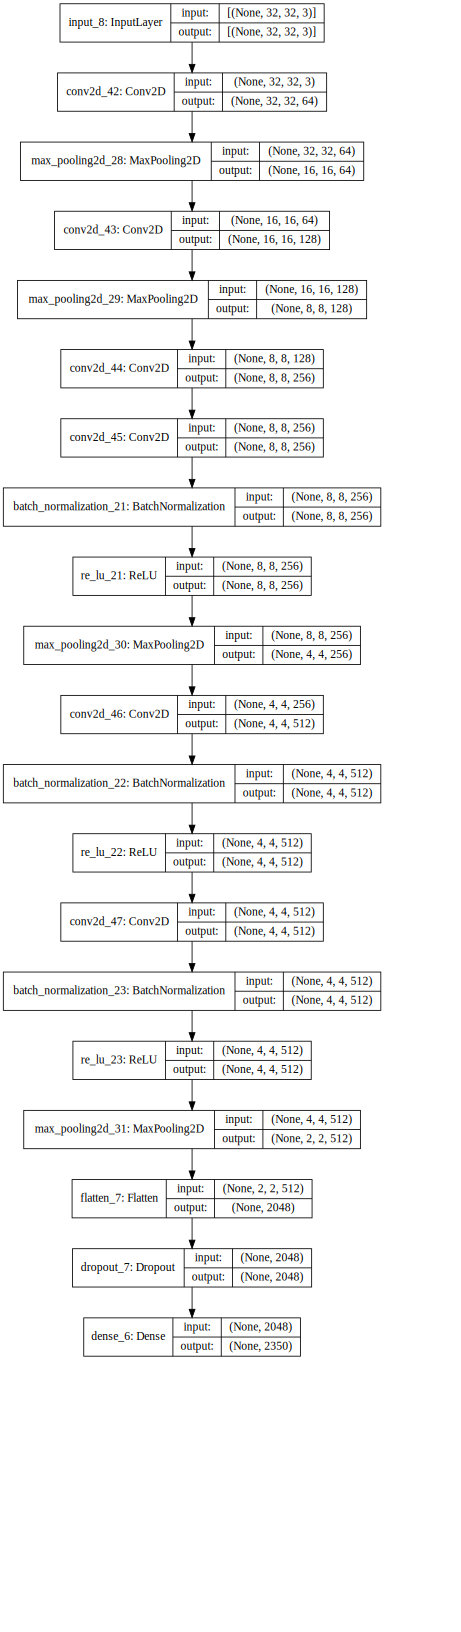

In [ ]:
import tensorflow as tf
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
%matplotlib inline


def myCNN(LetterClass, input_res=(32,32,3), output_channel=512): # 글자 목록 / 입력 해상도 / 출력 채널
    output_channel = [int(output_channel)/8, int(output_channel)/4, int(output_channel)/2, output_channel]

    '''
    Dense - 모든 퍼셉트론 연결
    2D Convolution Layer - 2차원 합성곱 레이어
    2D MaxPooling - 최댓값을 기준으로하는 다운샘플링
    Relu Function - Sigmoid 진화형 (이지만 함수 특성상 음수에서 뉴런이 죽는 상황 발생하기도 함)
    SoftMax Fuction - 다중클래스 분류용 (각 요소의 편차에 대한 최적화)
    Batch Nomalization - 배치 정규화, weight 값에 정규화작업을 해준다. 배치의 크기가 적절해야한다.
    '''

    '''
    학습시간 단축을 위해서 레이어를 조금 줄여볼까 생각했는데, 그러다가는 정확도랑 내 손모가지가 같이 날라갈 것 같아서 배치정규화 조금 더 추가한 정도...?
    아직 능지가 부족하기 때문에 2048로 가는 길에서 급격하게 다운샘플 시키면 아무래도 신경망에 좋지는 않겠지..
    '''

    inputs = tf.keras.layers.Input(input_res)
    outputs = tf.keras.layers.Conv2D(output_channel[0], 3, padding='same', activation='relu')(inputs) # 32x32x64
    outputs = tf.keras.layers.MaxPooling2D(2, 2)(outputs) # 16x16x64
    outputs = tf.keras.layers.Conv2D(output_channel[1], 3, padding='same', activation='relu')(outputs) # 16x16x128
    outputs = tf.keras.layers.MaxPooling2D(2, 2)(outputs) # 8x8x128
    outputs = tf.keras.layers.Conv2D(output_channel[2], 3, padding='same', activation='relu')(outputs) # 8x8x256
    outputs = tf.keras.layers.Conv2D(output_channel[2], 3, padding='same', activation='relu')(outputs) # 8x8x256
    outputs = tf.keras.layers.BatchNormalization()(outputs) # [Add] 요정도까지는 배치정규화 시켜도 괜찮지 않을까.. 해서.. 나의 시간은 소중하기 때문에.....
    outputs = tf.keras.layers.ReLU()(outputs) # [Add]
    outputs = tf.keras.layers.MaxPooling2D(2, 2)(outputs) # 4x4x256
    outputs = tf.keras.layers.Conv2D(output_channel[3], 3, padding='same', activation='relu', use_bias=False)(outputs) # 4x4x512
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = tf.keras.layers.ReLU()(outputs)
    outputs = tf.keras.layers.Conv2D(output_channel[3], 3, padding='same', activation='relu', use_bias=False)(outputs) # 4x4x512
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    outputs = tf.keras.layers.ReLU()(outputs)
    outputs = tf.keras.layers.MaxPooling2D(2, 2)(outputs) # 2x2x512
    outputs = tf.keras.layers.Flatten()(outputs) # 2048 -> 현대한글의 글자수는 2350개
    outputs = tf.keras.layers.Dropout(0.3)(outputs)
    outputs = tf.keras.layers.Dense(LetterClass, activation='softmax')(outputs)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)






SVG(model_to_dot(myCNN(2350), show_shapes=True, dpi=60).create(prog='dot', format='svg'))